# **Written Exam Economics winter 2024/2025**

**Advanced Macroeconomics: Structural Vector Autoregressive Analysis**
The topic for this project examination is the estimation of an IS-LM model following the analysis in Galí (1992). The basic underlying economic model is the same as in Galí but we will use the presence of cointegration to help us to identify the structural VAR model. The purpose of the examination is to assess your understanding of structural vector autoregressive (VAR) models. Substantial emphasis will be placed on using your programming skills in Matlab/Python. Specifically, the examination assesses theoretical and practical knowledge of structural vector autoregressive models within stationary and non-stationary frameworks

including assessing empirical results, using different approaches to identify VAR models and be able to use Matlab/Python to generate empirical results. You can use any Matlab/Python functions that you have programmed yourself or any function uploaded to Absalon during the course except when otherwise stated. You are not allowed to use other programs or built-in Matlab/Python functions except for those that are specified in the questions below. The assignment requires some additional coding.

Most questions in the examination are applied, concerning the empirical example outlined below. When you answer these empirical questions, please explain and motivate your answers as detailed as possible, preferably with reference to the underlying theory.

Consider the following data generating pro cess (DGP). Let the time series vector $x_t=\begin{pmatrix}y_t&i_t&\pi_t&m_t\end{pmatrix}'$ where $y_t$ is output, $i_t$ is the nominal interest rate, $\pi_t$ is inflation, and $m_t$ is money growth. We assume that the time series vector is generated by the following VAR model
$$x_t=\nu+A_1x_{t−1}+\cdots +A_px_{t−p}+u_t\tag{1}$$
where $\nu$ is a constant and $u_t$ is a vector of reduced form residuals with covariance matrix $\Sigma_u$. Assume that this time series vector is integrated of order one and that the cointegration rank is $r$.

As in the paper by Galí we assume that $m_t−\pi_t$ and $i_t−\pi_t$ are stationary relationships such that cointegration vector in this system is given by
$$\beta'=
\begin{pmatrix}
0&1&−1&0\\
0&0&−1&1
\end{pmatrix}$$
Under these assumptions we can rewrite the VAR model as the following VECM
$$
\Delta x_t=\nu+\alpha\beta'x_{t−1}+\Gamma_1\Delta x_{t−1}+\cdots+\Gamma_{p−1}\Delta x_{t−p−1}+v_t\tag{1}
$$
The assignment will guide you through an empirical analysis of the time series vector stated above including estimation and analysis of the cointegrated VAR model, identification of the structural cointegrated VAR model and robustness analysis.


<center>

### **Preamble**

</center>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)
import seaborn as sns
sns.set_palette("pastel") 

from IPython.display import display, Math, clear_output
from sympy import Matrix
from sympy import latex, symbols

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.tsatools import vech

from scipy.optimize import least_squares
from scipy.optimize import fsolve
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import f

from pathlib import Path
import pandas as pd
import numpy as np
import random
import sys
import os

import warnings
warnings.filterwarnings("ignore", message="Setting `xtol` below the machine epsilon")
warnings.filterwarnings("ignore", message="Setting `gtol` below the machine epsilon")
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 2

current_dir = Path.cwd()
sys.path.append(f"{current_dir}")

# Save output:
Python_path = None
LaTeX_path = None # LaTeX editor Texifier for macOS (https://www.texifier.com) highly recommended


pd.options.display.float_format = '{:.4f}'.format  # Ændrer til 4 decimale4

color_navy = '#{:02x}{:02x}{:02x}'.format(85, 108, 131)
colors_navy = ["#a5c6e2", "#80afd6", "#5b97ca", "#3b7fb9", "#2f6694", "#234c6f", "#17334a", "#0b1925"]
colors_pastel = sns.color_palette("pastel", 10)
colors_pastel

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [1]:
# Data:
result = pd.read_excel(f'{current_dir}/Data & Estimates/1000_2024.xlsx')

# Very important:
list_of_info = ["Dates: 1998-2014 (Monthly)","Labor Supply","Output", "Inflation","Nominal Interest Rate"]
list_of_info_latex = [r"$h_t$",r"$y_t$",r"$\pi_t$",r"$i_t$"]

K = len(result.drop(columns=["Dates"]).columns)

# Package/module:
from Structural_Vector_Autoregressive_Analysis import BaseClass

# Initialiser BaseClass med ønskede parametre
Base_initialize = BaseClass(LaTeX_path = None,                          # Can be None or LaTeX_path if LaTeX_path =! None it will save Tables/Plots to the LaTeX_path
                            Python_path = Python_path,                  # Path to Python folder
                            list_of_info_latex = list_of_info_latex,    # List of variable
                            list_of_info = list_of_info,                # List of names for each variable 
                            # Path to JCV.npy, PSSCV.npy and SigLevels.xlsx
                            path = f"{current_dir}/Data & Estimates/")    

from Structural_Vector_Autoregressive_Analysis import Initial_Tools as SVAR_IT
SVAR_IT = SVAR_IT(Base_initialize, date_column="Dates")

Assume that the time series vector $z_t$ is generated by the following structural VAR model:

$$z_t =\begin{bmatrix}\Delta h_t \\\Delta y_t \\\Delta \pi_t \\i_t - \pi_t\end{bmatrix}
=\Theta(L)
\begin{bmatrix}
\varepsilon^{ls}_t \\
\varepsilon^t_t \\
\varepsilon^{gm}_t \\
\varepsilon^{mm}_t
\end{bmatrix}
= \Theta(L) w_t
$$

where $\varepsilon^{ls}_t$ is the labor supply shock, $\varepsilon^t_t$ is the technology shock, $\varepsilon^{gm}_t$ is the goods market demand shock, and $\varepsilon^{mm}_t$ is the money market demand shock. We assume that the variance-covariance matrix of the structural shocks $\Sigma_w = I_4$.

##  $\text{1 Question}$
The long-run cumulative effects are summarized by $\Theta(1)$. A researcher specifies the following long-run multiplier:

$$
\Theta(1) =
\begin{bmatrix}
\theta_{11} & 0         & 0         & 0 \\
\theta_{21} & \theta_{22} & 0         & 0 \\
\theta_{31} & \theta_{32} & \theta_{33} & \theta_{34} \\
\theta_{41} & \theta_{42} & \theta_{43} & \theta_{44}
\end{bmatrix}
$$

Is the structural model over-, under-, or just-identified? Carefully explain and motivate your answer.

##  $\text{2 Question}$
Consider the reduced form VAR(3) model

$$
x_t = A_1 x_{t-1} + A_2 x_{t-2} + A_3 x_{t-3} + u_t
$$

Show that this reduced form VAR model can be rewritten as a reduced form VEC model given the basic assumptions made about the time series vector above. Explain in detail how you rewrite that VAR model as a VEC model.

##  $\text{3 Question}$
How many restrictions are needed in order to just-identify the underlying structural VAR(p) process? Compare to the number of restrictions implied by the long-run multiplier above. Provide a detailed motivation of your answer.

##  $\text{4 Question}$
Use the closed-form solution discussed during the course to identify the permanent shocks. Compute the long-run multiplier for the real interest rate. Interpret and compare to the long-run multiplier in question 1.

##  $\text{5 Question}$
The data is already transformed and ordered as in $x_t$. Note, however, that the scales are adjusted in order to make the data similar across all data sets. Plot the data in levels and in first dierences and perform graphical analysis in order to assess the degree of integration of all four variables.

In [2]:
result_diff = result[['h', 'y', 'pi', 'i']].diff(1)
result_diff['Dates'] = result['Dates']
result_diff = result_diff[['Dates','h', 'y', 'pi', 'i']].dropna()
result_diff

,Dates,h,y,pi,i
1,1998-02-01,4.5389,4.1963,-4.1981,1.6446
2,1998-03-01,3.8934,3.2913,2.9780,-1.3780
3,1998-04-01,11.2796,15.5530,-2.8034,0.2749
4,1998-05-01,8.7098,11.8474,2.6364,-0.0115
5,1998-06-01,16.3331,22.7059,-1.6919,0.1340
...,...,...,...,...,...
195,2014-04-01,3.6490,4.6449,-0.8188,0.9446
196,2014-05-01,-4.6672,-4.6766,-3.7529,0.2128
197,2014-06-01,-1.9672,3.2442,-1.9610,-0.9429
198,2014-07-01,-9.5101,-7.3905,0.3769,-0.8106


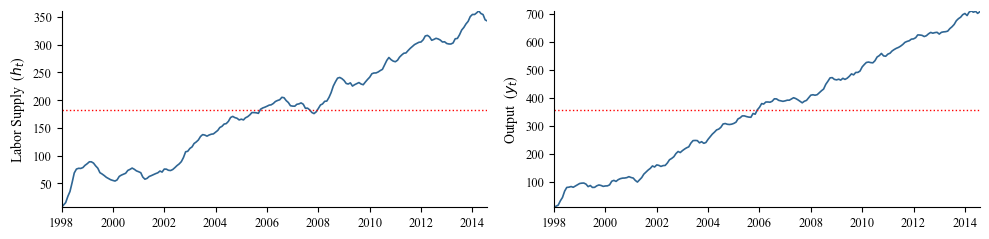

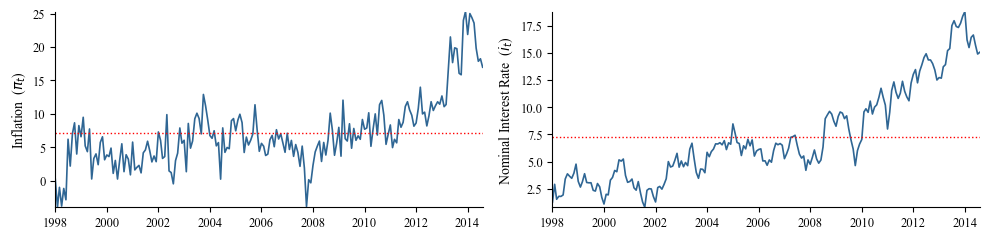

All variables have the same sample size: 200


,Mean,Median,Min,Max,Std. Dev.
Labor Supply,182.5245,185.3416,6.6846,360.7660,93.9612
Output,357.5045,382.7302,9.0905,709.4962,202.8624
Inflation,7.1712,6.1859,-3.9344,25.2998,5.2778
Nominal Interest Rate,7.2471,6.1473,0.7895,18.8027,4.3462


In [3]:
SVAR_IT.Data_plot(result,Save=False)
SVAR_IT.Descriptive_Statistics(result, display_data=True)
y_clean_data = SVAR_IT.clean_data(result,display_data=False)

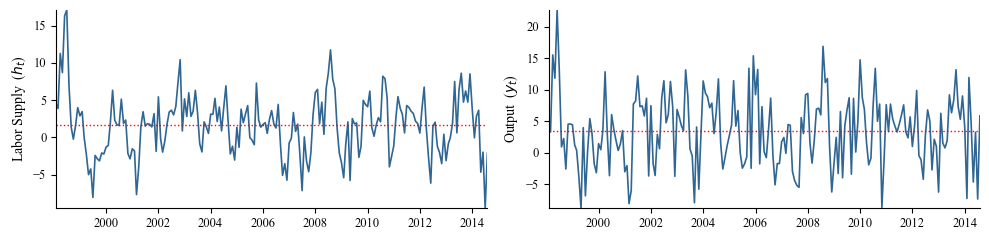

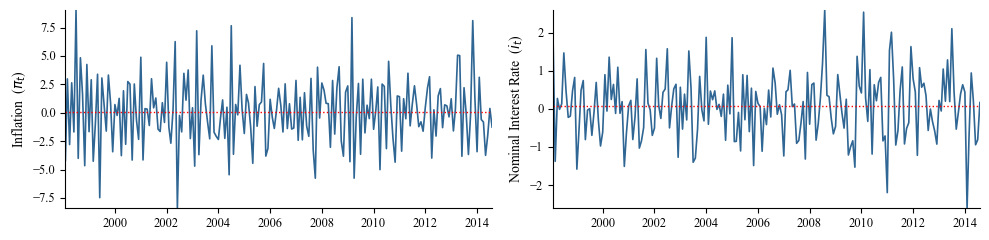

All variables have the same sample size: 199


,Mean,Median,Min,Max,Std. Dev.
Labor Supply,1.6877,1.8297,-9.5101,17.1169,4.0432
Output,3.5047,3.5158,-8.8567,22.7059,5.6341
Inflation,0.0840,0.3161,-8.4086,9.0447,2.9823
Nominal Interest Rate,0.0693,0.1003,-2.6111,2.5982,0.8568


In [4]:
SVAR_IT.Data_plot(result_diff,Save=False)
_ = SVAR_IT.Descriptive_Statistics(result_diff, display_data=True)

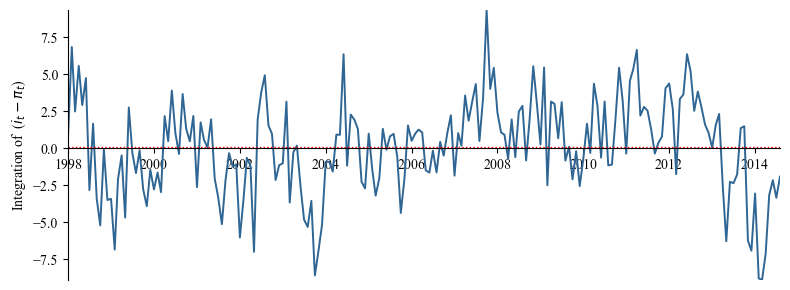

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))
SVAR_IT.setup_axis(axs, result['Dates'], 
                   result["i"]-result["pi"], 
                   ylabel=f"Integration of  ($i_t-\pi_t$)", 
                   font_props = font_props, 
                   colors_palette = colors_navy[4], 
                   linewidth_size = 1.4,
                   mean_line=True,
                   at_zero=True)
plt.tight_layout()
plt.show()

##  $\text{6 Question}$
Formulate a well-specied VAR model for $x_t$. Explain your workow and how you argue for your choice of the number of autoregressive lags in the VAR model.

In [6]:
from Structural_Vector_Autoregressive_Analysis import Lag_Order_Determination as SVAR_LOD
SVAR_LOD = SVAR_LOD(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Diagnostic_Testing as SVAR_DT
SVAR_DT = SVAR_DT(Base_initialize, y_dataframe=y_clean_data)
 
from Structural_Vector_Autoregressive_Analysis import Univariate_Diagnostic_Testing as SVAR_UDT
SVAR_UDT = SVAR_UDT(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Testing_Cointegration as SVAR_TC
SVAR_TC = SVAR_TC(Base_initialize, y_dataframe=y_clean_data)

In [7]:
_ = SVAR_LOD.Information_Criteria(maximum_lag_length=12, Trend=False, Show=True)

Lag,SIC,HQ,AIC
0,18.239789,18.198828,18.170928
1,7.019201,6.814397,6.674898
2,6.799074,6.430427,6.179330
3,7.147535,6.615044,6.252349
4,7.442769,6.746436,6.272141
5,7.780612,6.920435,6.334542
6,8.050691,7.026671,6.329179
7,8.415641,7.227778,6.418688
8,8.787172,7.435466,6.514777
9,9.080241,7.564691,6.532403


In [8]:
_ = SVAR_LOD.Top_Down_Sequence(maximum_lag_length=12, Trend=False, Show=True)
# # Michael Bergman's computed log-likelihood differs from this one.
# # LR test and p-value is the same.

Lag,Log. Likelihood,LR test,p-value
0,3408.134529,,
1,1214.880916,2193.253613,0.000000
2,1089.713984,125.166932,0.000000
3,1071.441544,18.272439,0.308187
4,1043.162568,28.278977,0.029277
5,1022.893938,20.268630,0.208365
6,989.885665,33.008273,0.007372
7,974.713321,15.172344,0.512054
8,960.777988,13.935334,0.603531
9,932.091850,28.686137,0.026140


In [9]:
SVAR_LOD.Combined_Lag_Selection(maximum_lag_length=12, Trend = False, LaTeX=False)

Lag,SIC,HQ,AIC,LR Test
0,18.240,18.199,18.171,
1,7.019,6.814,6.675,2193.254***
2,6.799,6.430,6.179,125.167***
3,7.148,6.615,6.252,18.272
4,7.443,6.746,6.272,28.279**
5,7.781,6.920,6.335,20.269
6,8.051,7.027,6.329,33.008***
7,8.416,7.228,6.419,15.172
8,8.787,7.435,6.515,13.935
9,9.080,7.565,6.532,28.686**


##  $\text{7 Question}$
Test for multivariate autocorrelation, heteroscedasticity and normality. Does your model satisfy the underlying assumptions? If the multivariate tests of autocorrelation and ARCH reject the null hypotheses, apply univariate tests for autocorrelation and ARCH in the residuals in each equation. You are allowed to use the built-in Matlab functions
lbqtest and archtest or the function owndiag included in the Python package `Ownfunctions.py` as alternatives to own functions.

In [10]:
SVAR_DT.Eigenvalue_Long_Table(maximum_lag_length=3,LaTeX=False)

Lags,Eigenvalues,h_t,y_t,\pi_t,i_t,Trend,Constant
Lag 1,λ_{p=1},1.007027,0.974844,0.893011,0.501722,False,False
,λ_{p=1},1.005033,0.879671,0.852338,0.501229,True,False
,λ_{p=1},1.000428,0.946343,0.881262,0.501196,False,True
,λ_{p=1},0.904202,0.904202,0.855811,0.499227,True,True
Lag 2,λ_{p=1},1.006752,0.950929,0.906721,0.728580,False,False
,λ_{p=2},0.471776,0.330970,0.156085,0.057109,False,False
,λ_{p=1},0.943593,0.907458,0.794889,0.794889,True,False
,λ_{p=2},0.494605,0.327084,0.160213,0.051364,True,False
,λ_{p=1},1.000516,0.911090,0.812177,0.812177,False,True
,λ_{p=2},0.487760,0.330572,0.120729,0.039831,False,True


In [11]:
SVAR_DT.Eigenvalue_Short_Table(maximum_lag_length=3, LaTeX=False)

Lag,"No Constant, No Trend",Constant Only,Trend Only,Constant and Trend
1,1.007027,1.000428,1.005033,0.904202
2,1.006752,1.000516,0.943593,0.912753
3,1.006565,1.000193,0.920182,0.914236


In [12]:
Constant = True
Trend = False
p = 2 # VAR Lags

_, _, _, residuals, _, SIGMA = SVAR_DT.VAR_estimation_with_exogenous(lags=p,Constant=Constant,Trend=Trend)
lags_q = 2 # ARCH Lags
lag_h = 6  # Autocorrelation (LM and Portmanteau)

In [13]:
SVAR_DT.Multivariate_ARCH(residuals=residuals, lags_q=lags_q)

,Test,Doornik_Hendry
0,Test statistic,221.9599
1,P-value,0.1371
2,Degrees of freedom,200.0000


In [14]:
SVAR_DT.Multivariate_Normality(residuals=residuals)

,Test,Doornik_Hansen,Lutkepohl
0,Joint test statistic:,8.1349,4.8027
1,P-value,0.4204,0.7784
2,Degrees of freedom,8.0000,8.0000
3,Skewness only,4.4589,4.5805
4,P-value,0.3474,0.3331
5,Kurtosis only,3.6760,0.2222
6,P-value,0.4516,0.9943


In [15]:
SVAR_DT.Multivariate_Portmanteau(residuals=residuals, lag_h=lag_h, lags=p)

,,Portmanteau,Modified Portmanteau
0,Test Statistic,95.5779,97.5713
1,p-value,0.0064,0.0044
2,Degrees of Freedom,64.0000,64.0000


In [16]:
SVAR_DT.Autocorrelation_LM_Table(lags=p, Constant=Constant, Trend=Trend, Exogenous=None, lags_h=lag_h, LaTeX=False)

Lags (h),Breusch Godfrey,Edgerton Shukur
1,16.043,0.956
2,40.643,1.228
3,66.474**,1.351*
4,91.542**,1.421**
5,107.895**,1.335**
6,132.849***,1.391**


In [17]:
SVAR_DT.Diagnostic_Table(residuals = residuals, 
                         Constant = Constant, 
                         lags_q = lags_q, 
                         lags_h = lag_h,
                         Trend = Trend, 
                         lags = p,
                         LaTeX = False)

,Doornik Hendry,Doornik Hansen,Lutkepohl,Portmanteau,Portmanteau Modified
Joint test,221.96,8.135,4.803,95.578***,97.571***
Skewness test,,4.459,4.58,,
Kurtosis test,,3.676,0.222,,


#### $$\text{Univariate Tests for {\small ARCH}, Normality, and Autocorrelation}$$

In [18]:
print("\nUnivariate ARCH Test - Het_ARCH")
display(SVAR_UDT.Univariate_ARCH_Test(residuals=residuals,lags=p))
print("\nUnivariate Normality Test - Jarque_Bera")
display(SVAR_UDT.Univariate_Normality_Test(residuals=residuals))
print("\nUnivariate Autocorrelation Test - Ljung-Box")
display(SVAR_UDT.Univariate_Autocorrelation_Test(residuals=residuals, lag_h=lag_h))

SVAR_UDT.Combined_Univariate_LaTeX(residuals=residuals,lags=p,lag_h=lag_h, LaTeX=False)


Univariate ARCH Test - Het_ARCH


,Hypothesis,P-Value,Test Statistic,Critical Value
Labor Supply,0.0000,0.8090,0.4239,5.9915
Output,0.0000,0.0657,5.4454,5.9915
Inflation,0.0000,0.3357,2.1833,5.9915
Nominal Interest Rate,0.0000,0.5233,1.2952,5.9915



Univariate Normality Test - Jarque_Bera


,Hypothesis,P-Value,Test Statistic,Critical Value
Labor Supply,0.0000,0.8864,0.2412,5.9915
Output,0.0000,0.7078,0.6911,5.9915
Inflation,0.0000,0.0803,5.0438,5.9915
Nominal Interest Rate,0.0000,0.7762,0.5067,5.9915



Univariate Autocorrelation Test - Ljung-Box


,Labor Supply,Output,Inflation,Nominal Interest Rate
Lag 1,0.7255,0.0027,0.2243,0.1904
Lag 2,2.8668,0.3854,1.2748,0.4509
Lag 3,3.2887,1.8199,2.0039,5.6869
Lag 4,3.4888,7.9508*,2.2725,7.0291
Lag 5,3.9041,11.1103**,2.7202,7.6434
Lag 6,4.3846,11.2459*,3.0836,7.6485


##  $\text{8 Question}$
For your preferred model, proceed by testing for cointegration using the Matlab/Python function `jcitest`. Explain your approach and how you nd the number of cointegration vectors, that is, the rank $r$, in the system allowing for ($i$) a constant term in the cointegration vector and ($ii$) both a constant and a linear trend in the cointegration vector. Do you use dierent sources of information when determining the rank? If so, explain how you arrive at your decision.

In [19]:
_ = SVAR_TC.Trace_Test(lags=p, p_value_threshold=0.05, LaTeX=False)

,1/H2/n,2/H1*/co,3/H1/ci,4/H*/cili,5/H/colo
0,82.239*** (λ=0.1822),100.843*** (λ=0.2141),61.766*** (λ=0.1871),85.094*** (λ=0.1964),84.244*** (λ=0.195)
1,42.41*** (λ=0.1458),53.136*** (λ=0.152),20.749 (λ=0.0596),41.803* (λ=0.1052),41.305*** (λ=0.1039)
2,11.196* (λ=0.0428),20.498** (λ=0.0586),8.591 (λ=0.0422),19.805 (λ=0.0566),19.59** (λ=0.0564)
3,2.537 (λ=0.0127),8.537* (λ=0.0422),0.05 (λ=0.0003),8.267 (λ=0.0409),8.088*** (λ=0.04)
Pantula,2,3,1,1,4


Sample: 198. Lag length: VAR: p=2 and VEC: p=1. Test statistic with Eigenvalue
in parentheses and the significance level as a superscript (10%, 5% and 1%).
Pantula principle at a 5%


In [20]:
cointegration_vectors, rank = SVAR_TC.Cointegration_Vectors(preferred_model=3, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=[3], 
                                rank=None,LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 3  |  Model: H1 ("ci") [constant in coint vec and linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 61.766 p-value: 0.0019 ( *** ) and λ = 0.1871
     Rank: 1 LR: 20.749 p-value: 0.4099 (  ) and λ = 0.0596

 \begin{pmatrix}  -0.03779 & 0.00489 & -0.43052 & 1.00000 \end{pmatrix} 


In [21]:
_, _ = SVAR_TC.Cointegration_Vectors(preferred_model=4, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=[3], 
                                rank=None, LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 4  |  Model: H* ("cili") [constant and linear trend in coint vec, linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 85.094 p-value: 0.001 ( *** ) and λ = 0.1964
     Rank: 1 LR: 41.803 p-value: 0.0644 ( * ) and λ = 0.1052

 \begin{pmatrix}  -0.11226 & 0.08222 & -0.36238 & 1.00000 \end{pmatrix} 


##  $\text{9 Question}$
Impose your preferred rank and test the null hypothesis that there is no linear trend in the cointegration vectors.

In [22]:
LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bcon'], cons=SVAR_TC.zero_array(K+1)[K], model='H*', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "include a constant but not\na trend" if pval > threshold else "include both a constant\nand a trend"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}.\n"
      f"We {decision} the null that the trend in the cointegration \n"
      f"vector is zero, suggesting we should {conclusion}.")

print("\n   The freely estimated cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 2.2729 with a p-value of 0.1317.
We cannot reject the null that the trend in the cointegration 
vector is zero, suggesting we should include a constant but not
a trend.

   The freely estimated cointegration vector:


<IPython.core.display.Math object>

## $\text{10 Question}$
Continue with your preferred rank and the preferred specication of the deterministic component in the cointegration vector found in the previous question and test hypotheses on the cointegration space using the Matlab function jcontest or the Python function johcontest included in the package `TracetestNew.py`. Test for exclusion, stationarity and weak exogeneity. Explain the meanings of these tests and draw conclusions.

In [23]:
print(f"For rank = {rank} and lags = {p-1}")
SVAR_TC.Stationary_Exclusion_Exogeneity(rank=float(rank), lags=p, LaTeX=False)

# Long run time

For rank = 1 and lags = 1


,,Stationarity,,Exclusion,,Weak Exogeneity
Labor Supply,,39.637***,,1.451,,3.24*
Output,,40.181***,,0.14,,0.764
Inflation,,33.025***,,19.561***,,17.134***
Nominal Interest Rate,,39.401***,,26.096***,,10.846***


## $\text{11 Question}$
Interpret the unrestricted estimated cointegration vectors in light of the theoretical cointegration vectors. Do you find plausible values of the parameters in the estimated cointegration vectors? Interpret the unrestricted estimates of the adjustment parameters.

In [24]:
_, _, _, _, _, beta, alpha, _, _, _, _, _, _, _, _ = SVAR_TC.jcitest(p-1, model=3)
print("beta_hat",beta[:,int(rank)-1])
print("alpha_hat",alpha[:,int(rank)-1])
print("\nbeta_hat",cointegration_vectors[0],"Normalised")
print("alpha_hat",alpha[:,int(rank)-1]/alpha[:,int(rank)-1][3],"Normalised")

beta_hat [0.0261 -0.0034 0.2970 -0.6899]
alpha_hat [-0.4676 -0.3511 -0.8496 0.2155]

beta_hat [-0.0378 0.0049 -0.4305 1.0000] Normalised
alpha_hat [-2.1700 -1.6293 -3.9431 1.0000] Normalised


## $\text{12 Question}$
Test formally whether the theoretical cointegration vectors are in line with the information in the data using the Matlab function jcontest or the Python function johcontest. Explain how these tests relate to the exclusion and stationarity tests.

In [25]:
RR = np.transpose(np.array([[0, 0, -1, 1]], dtype=np.float64))  # Restriktion: realrente = 0

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=float(rank), test=['bvec'], cons=RR, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 12.4552 with a p-value of 0.0060. This
suggests that we reject the null that the cointegration
relationship do not exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

In [26]:
RR = np.transpose(np.array([[0, 0, 1, 1]], dtype=np.float64))

LRtest, pval, _, _, Brest, _, _, _, _ = SVAR_TC.johcontest(r=rank, 
                       test=['bcon'], cons = RR, model='H1', 
                       lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 11.0934 with a p-value of 0.0009. This
suggests that we reject the null that the cointegration
relationship do not exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

## $\text{13 Question}$
Plot both the unrestricted and theoretical cointegration vectors. Interpret your results.

In [27]:
for i, val in enumerate(list_of_info):
    print(f"Index: {i}:   {val}" + (f" ({list_of_info_latex[i-1]})" if i > 0 else ""))

Index: 0:   Dates: 1998-2014 (Monthly)
Index: 1:   Labor Supply ($h_t$)
Index: 2:   Output ($y_t$)
Index: 3:   Inflation ($\pi_t$)
Index: 4:   Nominal Interest Rate ($i_t$)


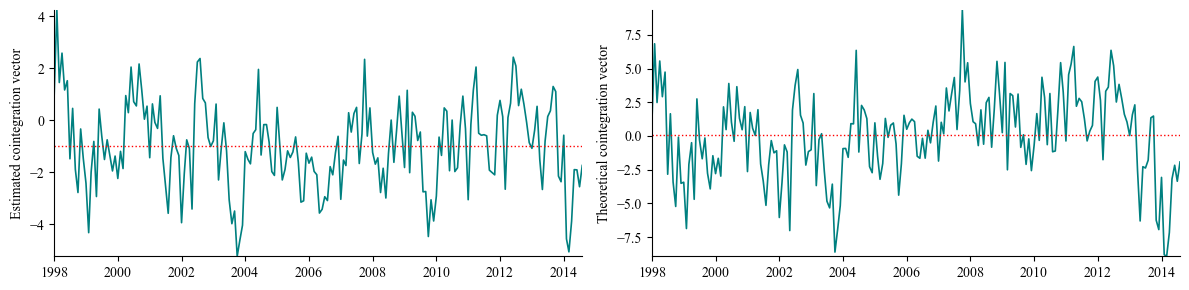

The correlation between cointvec and theory is: 0.8328


In [28]:
cointvec = np.dot(cointegration_vectors[0],np.array(y_clean_data).T)
theory = np.dot(np.array([0,0,-1,1]),np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result["Dates"], cointvec, f"Estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False])
SVAR_IT.setup_axis(axs[1], result["Dates"], theory, f"Theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False])
plt.tight_layout()
plt.show()

print(f"The correlation between cointvec and theory is: {round(np.corrcoef(cointvec, theory)[0, 1],4)}")

## $\text{14 Question}$
Impose $r = 1$ and the theoretical cointegration vectors and re-estimate the VEC model using the full sample and using your preferred lag length found above. Interpret the adjustment coecients in light of the theoretical cointegration vectors. Do you nd the expected signs on the adjustment coecients?

In [29]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC
SVAR_IRC = SVAR_IRC(Base_initialize,y_dataframe=y_clean_data, horizon = 25, lags=p, Constant=Constant, Trend=Trend, Exogenous=None)
Beta_theory = np.array([[0,0,-1,1]])
rank = 1

linear_combinations = {"Real interest": [f"{list_of_info[4]} - {list_of_info[3]}"],
                       # Add more:
                       }

print("\nLinear Combinations")
if not linear_combinations:
    linear_combinations = None
    print("  None")
else:
    for name, expressions in linear_combinations.items():
        for expr in expressions:
            print(f"  {name} = {expr}")

The estimated VAR model may be unstable due to largest absolute eigenvalue is greater than or equal to 1. 
Review the model specification for potential adjustments.
Max Eigenvalue = 1.001


Linear Combinations
  Real interest = Nominal Interest Rate - Inflation


In [30]:
model = 3
beta = SVAR_TC.Initilize_beta_vecm(lags=p,model=model, beta_theory=Beta_theory.T, rank=int(rank)).T
Beta, Betavec, SEBeta, tratioBeta, res, so, so_ml = SVAR_TC.LSKnownBeta(lags=p, beta=beta, model=model)
Beta = Beta.T
tratioBeta = tratioBeta.T

GAMMA = Beta[:,0:K*(p-1)]               # first diff lags
alpha = Aest = Beta[:,K*(p-1):len(Beta.T)-1]   # speed of adjustment

tratioBeta_re = tratioBeta.reshape(-1, Beta.shape[1])
alpha_tratio = tratioBeta_re[:,K*(p-1):len(tratioBeta_re.T)-1]

print("Least Squares:")
print("    Alpha estimates:",alpha.T,"")
print("    Alpha t-ratios: ",alpha_tratio.T)

alpha, Gamma, SigmaML, u = SVAR_IRC.VECMknown(beta=Beta_theory.T)

print("\nMaximum Likelihood ")
print("    Alpha estimates:",alpha.T)

print("\nEquivalent: ~",np.allclose((alpha - Beta[:,K*(p-1):len(Beta.T)-1]),0))

Least Squares:
    Alpha estimates: [[0.1727 0.1322 0.3165 -0.0352]] 
    Alpha t-ratios:  [[2.1937 0.9939 5.0285 -1.6852]]

Maximum Likelihood 
    Alpha estimates: [[0.1727 0.1322 0.3165 -0.0352]]

Equivalent: ~ True


## $\text{15 Question}$
Implement the identication scheme suggested above in questions 3 and 4 using the Matlab/Python solver of non-linear systems of equations. In Matlab you can use `fsolve` and in Python either `fsolve` or `least_squares`. Check that the solution is valid and compute the variance-covariance matrix of the identied structural shocks. Please, provide the Matlab/Python code you are using to identify the shocks in the appendix

In [31]:
SVAR_TC.Identication_Scheme(rank)

Since the rank r = 1, there are 1 transitory/temporary shocks.
Thus, there are K-r = 3 permanent shocks.

    To identify the permanent shocks, we need (K-r)(K-r-1)/2 = 3 restrictions. (Upsilon)
    To identify the transitory shocks, we need r(r-1)/2 = 0 restrictions. (B^{-1}_0)


In [32]:
B_R = """[ * * * *
           * * * *
           * * * *
           * * * *]"""

U_R = """[ * 0 0 0
           * * 0 0
           * * * 0 
           * * * 0]"""

In [33]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=False)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K))#, xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))
Upsilon_solve = Xi @ B0inv
B0inv_solve = B0inv

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
2.78474 & -0.59723 & 0.30633 & -1.23078 \\
4.17210 & 3.03547 & 0.48198 & -0.94196 \\
-0.17800 & -0.45442 & 0.94207 & -2.25565 \\
0.33569 & -0.14341 & 0.69811 & 0.25070 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
7.92237 & -0.00000 & -0.00000 & -0.00000 \\
7.96986 & 3.64722 & 0.00000 & 0.00000 \\
0.51465 & -0.08162 & 0.67485 & 0.00000 \\
0.51465 & -0.08162 & 0.67485 & 0.00000 \\
\end{pmatrix}


## $\text{16 Question}$
Compute impulse response functions and forecast error variance decomposition of the data including the real interest rate. Focus only on the eects of the permanent shock(s). Use bootstrap (the standard residual based recursive design bootstrap or wild bootstrap) to compute condence intervals based on bootstrap standard error estimates (for the
impulse responses) and Efron's percentile intervals (for the variance decomposition). It is important that you clearly state which bootstrap method you use and how you check the order condition in each bootstrap replication. You can show forecast error variance decomposition either in a table or in a graph. Interpret your results. Are permanent shocks more or less important for output than transitory shocks?

In [34]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd = SVAR_IRC.FEVD_IRF(irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=None)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=None)

In [35]:
IRFmat, VCmat = SVAR_IRC.VEC_Bootstrap(Bootstrap = True, 
                                       Bootstrap_type = "Wild", 
                                       Orthogonal = False, 
                                       iterations = None, 
                                       B0inv_R = B_R, 
                                       Upsilon_R = U_R, 
                                       rank = rank,
                                       n_trials=500, 
                                       Beta_theory = Beta_theory, 
                                       Umat = None, 
                                       Upsilon0 = None,
                                       estimator = "Numerical", 
                                       initial_guess = B0inv,
                                       linear_combinations = linear_combinations) # None or linear_combinations

Initial settings and model checks
      Xi satisfies assumptions
      Identification of transitory shocks is valid
      Solver works correctly.

Numerical Solver (least_squares)

Trial: 500 of 500  |  Failures due to solver: 0 | Failures due to unstable eigenvalue: 0

  Bootstrap based on: 500 trials
  Estimator type in use: Numerical
  Bootstrap type in use: Wild

Total errors: 0
     Errors due to unstable replications: 0
     Errors due to Xi not satisfying assumptions: 0
     Errors due to solver failure to converge: 0


Impulse Response Function
Bootstrap (Wild) Confidence Intervals (Delta)


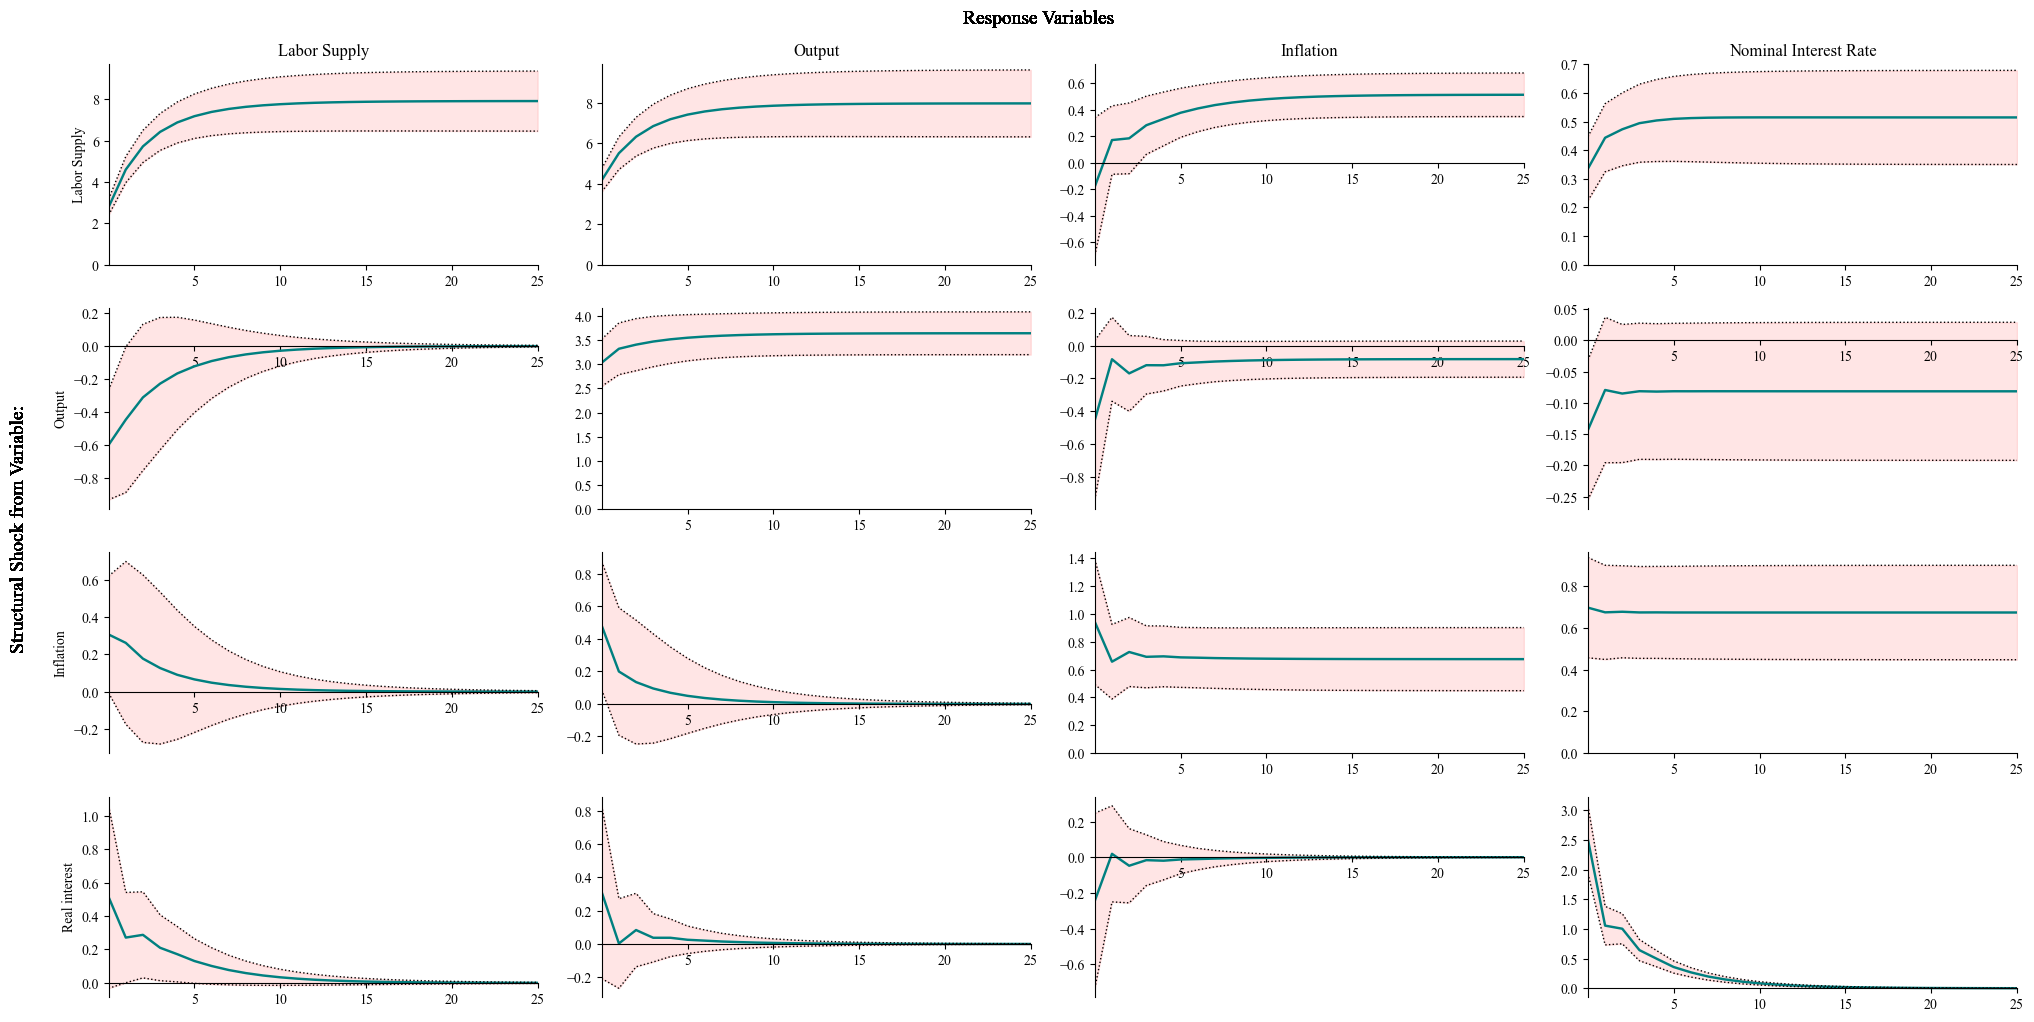

In [36]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = linear_combinations, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta",  # or "Efron" can be extended.
    responses = [1,2,3,4],      # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2,3,4],         # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68],            # mulitple e.g. z_values=[95,68]
    Baseline = irf,             
    Info="Wild",                # VEC_Bootstrap() setting
    )

Forecast Error Variance Decomposition
Bootstrap (Wild) confidence intervals (Efron)


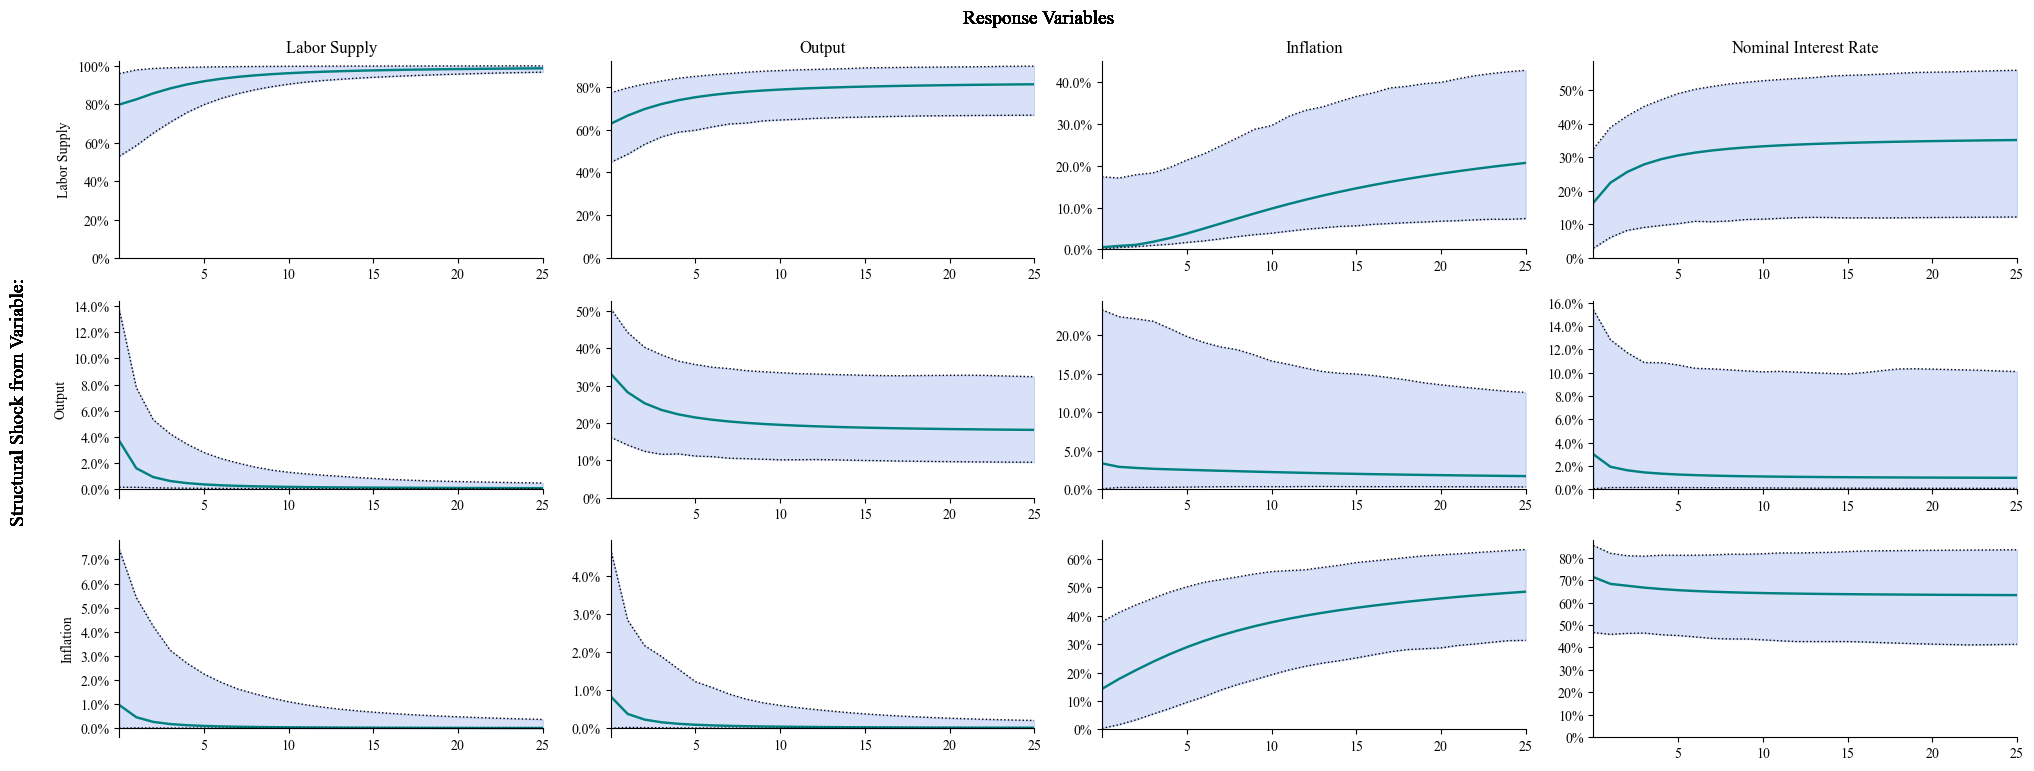

In [37]:
SVAR_IRC.FEVD_Combined_Plots(
    Bootstrap_Matrix = VCmat,
    confidence_type ="Efron", # can be extended.
    responses = [1,2,3,4], # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2,3],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68], # mulitple e.g. z_values=[95,68]
    Baseline = fevd*100, 
    Info="Wild",
    )

## $\text{17 Question}$
Instead of implementing the theoretical cointegration vector you can use the estimated cointegration vector still imposing $r=1$. Identify the structural shocks and plot the implied impulse responses of output to all four shocks together with condence bands. Compare your results to what you previously found using the theoretical cointegration vector. Comment!

In [38]:
Beta_theory = cointegration_vectors[0].reshape(1, -1)
Beta_theory = np.array(cointegration_vectors)

alpha, Gamma, SigmaML, u = SVAR_IRC.VECMknown(beta=Beta_theory.T)

In [39]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=False)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K)) #xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
2.89519 & -0.60707 & 0.20507 & -0.97210 \\
4.21579 & 3.05561 & 0.33582 & -0.72988 \\
0.14775 & -0.64690 & 1.65062 & -1.76639 \\
0.41890 & -0.16388 & 0.49397 & 0.44797 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
7.97387 & -0.00000 & 0.00000 & -0.00000 \\
7.95406 & 3.68683 & 0.00000 & 0.00000 \\
0.63875 & -0.22116 & 1.14607 & -0.00000 \\
0.53743 & -0.11323 & 0.49340 & -0.00000 \\
\end{pmatrix}


In [40]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd = SVAR_IRC.FEVD_IRF(irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=None)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=None)

In [41]:
IRFmat, VCmat = SVAR_IRC.VEC_Bootstrap(Bootstrap = True, 
                                       Bootstrap_type = "Wi ld", 
                                       Orthogonal = False, 
                                       iterations = None, 
                                       B0inv_R = B_R, 
                                       Upsilon_R = U_R, 
                                       rank = rank,
                                       n_trials=500, 
                                       Beta_theory = Beta_theory, 
                                       Umat = None, 
                                       Upsilon0 = None,
                                       estimator = "Numerical", 
                                       initial_guess = B0inv,
                                       linear_combinations = linear_combinations) # None or linear_combinations

Initial settings and model checks
      Xi satisfies assumptions
      Identification of transitory shocks is valid
      Solver works correctly.

Numerical Solver (least_squares)

Trial: 500 of 501  |  Failures due to solver: 1 | Failures due to unstable eigenvalue: 0

  Bootstrap based on: 500 trials
  Estimator type in use: Numerical
  Bootstrap type in use: Non parametric

Total errors: 1
     Errors due to unstable replications: 0
     Errors due to Xi not satisfying assumptions: 0
     Errors due to solver failure to converge: 1


Impulse Response Function
Bootstrap (Wild) Confidence Intervals (Delta)


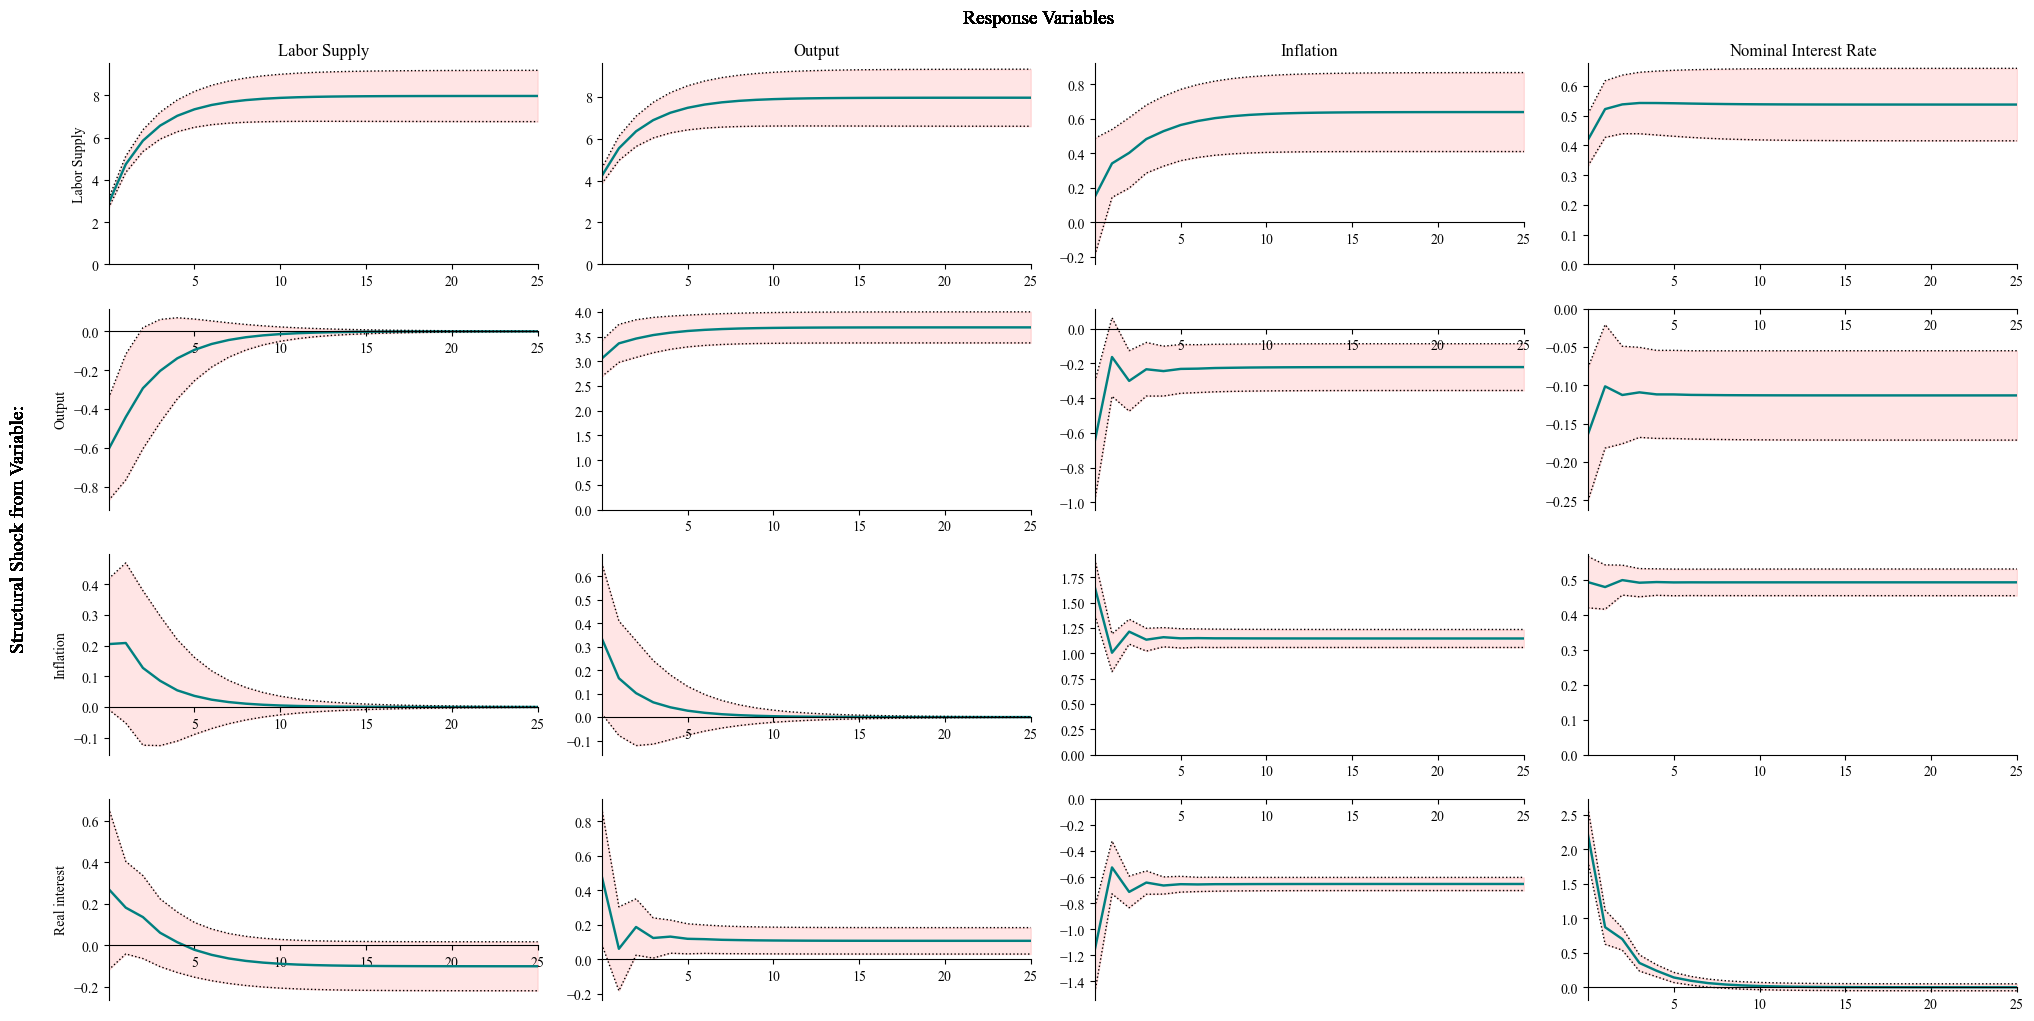

In [42]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = linear_combinations, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta", # or "Efron" can be extended.
    responses = [1,2,3,4], # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2,3,4],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68], # mulitple e.g. z_values=[95,68]
    Baseline = irf, 
    Info="Wild")

In [43]:
horizon = 10000
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC_test
SVAR_IRC_test = SVAR_IRC_test(Base_initialize,y_dataframe=y_clean_data, horizon = horizon, lags=2, Constant=Constant, Trend=Trend, Exogenous=None)
rank = 1

irf_temp = SVAR_IRC_test.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd_temp = SVAR_IRC_test.FEVD_IRF(irf_temp)

FEVD_result_temp = SVAR_IRC_test.FEVD_estimation(FEVD_var=fevd_temp, list_of_info=list_of_info, normalise=None)#list_of_info[3]) # None)


indices = [0, 1, 2, 5, 10, 20, 40, 10000]
data = {f"{list_of_info[i]}": FEVD_result_temp[list_of_info[i]][list_of_info[1]][indices] for i in range(1,5)}
fevd_table = pd.DataFrame(data, index=indices)
fevd_table*100

The estimated VAR model may be unstable due to largest absolute eigenvalue is greater than or equal to 1. 
Review the model specification for potential adjustments.
Max Eigenvalue = 1.001



,Labor Supply,Output,Inflation,Nominal Interest Rate
0,86.0792,3.7846,0.4319,9.7044
1,87.9826,1.6058,0.2440,10.1676
2,90.4366,0.9003,0.1412,8.5218
5,95.2973,0.3235,0.0510,4.3281
10,97.8929,0.1389,0.0219,1.9463
20,99.0455,0.0629,0.0099,0.8818
40,99.5455,0.0299,0.0047,0.4198
10000,99.9983,0.0001,0.0000,0.0016


## $\text{18 Question}$
Implement the closed form solution discussed above and compute the implied $B^{-1}_0$ matrix. Is it identical to the one you obtained using a solver? Please, provide the code you are using in the appendix. Note that you are not allowed to use the function `null()` in Matlab/Python to implement your identication.

In [44]:
Beta_theory = np.array([[0,0,-1,1]])
Aest, _, _, _ = SVAR_IRC.VECMknown(beta=Beta_theory.T)
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=False)

In [45]:
Beta_theory_latex = Matrix(Beta_theory)
Upsilon0_latex = Matrix([[symbols(f"\\Upsilon_{{{i+1}{j+1}}}^0") for j in range(int(K))] for i in range(int(K-rank))])

def matrix_to_latex(matrix):
    return r"\begin{pmatrix}" + r"\\ ".join([" & ".join(map(str, row)) for row in matrix.tolist()]) + r"\end{pmatrix}"

latex_expr = (fr"\begin{{equation}} 0=\underset{{({Beta_theory_latex.shape[0]}\times{int(rank)})}}{{\underset{{{Beta_theory_latex.shape}}}{{\beta'}} \underset{{({int(K)}\times{int(rank)})}}{{\Upsilon_0}}}} = " + matrix_to_latex(Beta_theory_latex) + matrix_to_latex(Upsilon0_latex.T) + "=" + matrix_to_latex(Beta_theory_latex * Upsilon0_latex.T) +r"\end{equation}").replace("*", "\\cdot")
display(Math(latex_expr.replace(", ","\\times ")))

<IPython.core.display.Math object>

In [46]:
Upsilon0 = np.array([[1,0,0],
                     [0,1,0],
                     [0,0,1],
                     [0,0,1]])

print("Beta @ Upsilon =",(Beta_theory @ Upsilon0), " ~ ", "Valid" if np.all(Beta_theory @ Upsilon0 == 0) else "Not valid")

Beta @ Upsilon = [[0 0 0]]  ~  Valid


In [47]:
pipit = np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.dot(Upsilon0.T,Upsilon0)),Upsilon0.T),Xi),SIGMA),np.dot(np.dot(np.linalg.inv(np.dot(Upsilon0.T,Upsilon0)),Upsilon0.T),Xi).T)            
pimat = np.linalg.cholesky(pipit)

Upsilon = np.dot(Upsilon0,pimat)                       
Fk = np.dot(np.dot(np.linalg.inv(np.dot(Upsilon.T,Upsilon)),Upsilon.T),Xi)
print('Fk matrix\n',Fk)

Umat = None

if Umat is None:
   Umat = np.zeros((int(rank), K))  # Antager en nulmatrix af størrelse r x K
   for i in range(1, int(rank) + 1):
      Umat[i - 1, K - i] = 1  # Python-indeks starter fra 0

if np.linalg.det(np.dot(Umat,Aest)) == 0:
   print('\n Identification of transitory shock is invalid')
else:
   print('\n Identification of transitory shocks is valid')

xi = np.dot(Aest,np.linalg.inv(np.dot(Umat,Aest)))  

i=0
while i < K:
   j=0
   while j< int(rank):
      if abs(xi[i,j]) < 1E-8: #just to make sure that elements are = 0
         xi[i,j] = 0
      j=j+1
   i=i+1

qr=np.linalg.cholesky(np.dot(np.dot(xi.T,np.linalg.inv(SIGMA)),xi))                   
Fr=np.dot(np.dot(np.linalg.inv(qr),xi.T),np.linalg.inv(SIGMA))
print('\n Fr matrix\n',Fr)

# Putting it all together to compute B0inv
invB0 = np.linalg.inv(np.vstack((Fk,Fr)))

print("\nB_0^{-1}\n",invB0)
print("")
print('\n(1) beta*Xi should be zero\n',np.dot(Beta_theory,Xi))
print('\n(2) beta*Upsilon_0 should be zero\n',np.dot(Beta_theory,Upsilon0))
print('\n(3) C(1)*B0^{-1} should be Upsilon~zeros(K,r)\n',np.dot(-Xi,invB0))
print('\nwhere Upsilon\n',Upsilon)
print('\n(4) Covariance matrix of structural shocks w_t should be I_K\n',np.dot(np.dot(np.linalg.inv(invB0),SIGMA),np.linalg.inv(invB0).T))
print('\nShould be diagonal\n',np.dot(np.dot(np.dot(np.dot(np.linalg.inv(qr),xi.T),np.linalg.inv(SIGMA)),xi),np.linalg.inv(qr.T))    )
print('\nThis compares Upsilon solver and closed form solution\n',Upsilon[:,0:K-int(rank)+1],'\n',Upsilon_solve[:,0:K-int(rank)+1],"\n")
Upsilon_Warne = np.dot(Xi,invB0)
B0inv_Warne = invB0

Fk matrix
 [[0.2872 0.0353 -0.1636 0.0704]
 [-0.3726 0.2622 0.0799 -0.1253]
 [-0.2030 0.0494 0.2221 1.1876]]

 Identification of transitory shocks is valid

 Fr matrix
 [[-0.0324 -0.0350 -0.3537 0.5157]]

B_0^{-1}
 [[2.7847 -0.5972 0.3063 -1.2308]
 [4.1721 3.0355 0.4820 -0.9420]
 [-0.1780 -0.4544 0.9421 -2.2556]
 [0.3357 -0.1434 0.6981 0.2507]]


(1) beta*Xi should be zero
 [[-0.0000 -0.0000 0.0000 -0.0000]]

(2) beta*Upsilon_0 should be zero
 [[0 0 0]]

(3) C(1)*B0^{-1} should be Upsilon~zeros(K,r)
 [[-7.9224 0.0000 0.0000 0.0000]
 [-7.9699 -3.6472 0.0000 0.0000]
 [-0.5146 0.0816 -0.6748 0.0000]
 [-0.5146 0.0816 -0.6748 0.0000]]

where Upsilon
 [[7.9224 0.0000 0.0000]
 [7.9699 3.6472 0.0000]
 [0.5146 -0.0816 0.6748]
 [0.5146 -0.0816 0.6748]]

(4) Covariance matrix of structural shocks w_t should be I_K
 [[1.0000 0.0000 0.0000 0.0000]
 [-0.0000 1.0000 0.0000 -0.0000]
 [0.0000 0.0000 1.0000 -0.0000]
 [0.0000 -0.0000 -0.0000 1.0000]]

Should be diagonal
 [[1.0000]]

This compares Upsilon

In [48]:
print("Upsilon  ≈  Upsilon (solve)   ~  ",np.allclose(Upsilon_Warne, Upsilon_solve))
print("B_0^{-1} ≈  B_0^{-1} (solve)  ~  ",np.allclose(B0inv_Warne, B0inv_solve))

print("\nDifference (Maximum)")
print(f"    B_0^{{-1}}:  {np.max(B0inv_Warne - B0inv_solve):.25f}")
print(f"    Upsilon:   {np.max(Upsilon_Warne - Upsilon_solve):.25f}")

def matrix(matrix, name):
    string = f"$$\n{name} = \\begin{{pmatrix}}\n"
    rows, cols = matrix.shape
    for i in range(rows):
        row = " & ".join([f"{matrix[i, j]:.10f}" for j in range(cols)])
        string += row + " \\\\\n"
    string += "\\end{pmatrix}\n$$"
    return string

display(Math(matrix(B0inv_solve, "\\underset{(\\textit{Solver})}{B_{0}^{-1}}")))
display(Math(matrix(B0inv_Warne, "\\underset{(\\textit{Warne})}{B_{0}^{-1}}")))
print("")
display(Math(matrix(Upsilon_solve, "\\underset{(\\textit{Solver})}{\\Upsilon_{0}}")))
display(Math(matrix(Upsilon_Warne, "\\underset{(\\textit{Warne})}{\\Upsilon_{0}}")))

Upsilon  ≈  Upsilon (solve)   ~   True
B_0^{-1} ≈  B_0^{-1} (solve)  ~   True

Difference (Maximum)
    B_0^{-1}:  0.0000000000000008881784197
    Upsilon:   0.0000000000000026645352591


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [49]:
if "True" == "True":
    print(matrix(B0inv_solve,   r"\underset{(\textit{Solver})}{B_{0}^{-1}}"),"\n")
    print(matrix(B0inv_Warne,   r"\underset{(\textit{Warne})}{B_{0}^{-1}}" ),"\n")
    print(matrix(Upsilon_solve, r"\underset{(\textit{Solver})}{\Upsilon_0}"),"\n")
    print(matrix(Upsilon_Warne, r"\underset{(\textit{Warne})}{\Upsilon_0}" ),"\n")

$$
\underset{(\textit{Solver})}{B_{0}^{-1}} = \begin{pmatrix}
2.7847437409 & -0.5972336847 & 0.3063265244 & -1.2307785689 \\
4.1720992444 & 3.0354689324 & 0.4819821853 & -0.9419638340 \\
-0.1779974319 & -0.4544184539 & 0.9420696824 & -2.2556478154 \\
0.3356879004 & -0.1434079423 & 0.6981072839 & 0.2507044139 \\
\end{pmatrix}
$$ 

$$
\underset{(\textit{Warne})}{B_{0}^{-1}} = \begin{pmatrix}
2.7847437409 & -0.5972336847 & 0.3063265244 & -1.2307785689 \\
4.1720992444 & 3.0354689324 & 0.4819821853 & -0.9419638340 \\
-0.1779974319 & -0.4544184539 & 0.9420696824 & -2.2556478154 \\
0.3356879004 & -0.1434079423 & 0.6981072839 & 0.2507044139 \\
\end{pmatrix}
$$ 

$$
\underset{(\textit{Solver})}{\Upsilon_0} = \begin{pmatrix}
7.9223697880 & -0.0000000000 & -0.0000000000 & -0.0000000000 \\
7.9698598166 & 3.6472183394 & 0.0000000000 & 0.0000000000 \\
0.5146496151 & -0.0816165380 & 0.6748466109 & 0.0000000000 \\
0.5146496151 & -0.0816165380 & 0.6748466109 & 0.0000000000 \\
\end{pmatrix}
$$ 

$$
\und